In [4]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.applications import resnet, ResNet50,VGG16,ResNet101, VGG19
import cv2
import random
import shutil
import imutils
from PIL import Image

In [5]:
src_dir = './dataset/'

In [6]:
# Set variable for sub-directories
normal_dir = os.path.join(src_dir, 'normal')
cataract_dir = os.path.join(src_dir, 'cataract')
glaucoma_dir = os.path.join(src_dir, 'glaucoma')
diabetic_retinopathy_dir = os.path.join(src_dir, 'diabetic_retinopathy')

# Get the list of all the images
normal_dir_content = os.listdir(normal_dir)
cataract_dir_content = os.listdir(cataract_dir)
glaucoma_dir_content = os.listdir(glaucoma_dir)
diabetic_retinopathy_dir_content = os.listdir(diabetic_retinopathy_dir)

# shuffle the data
random.shuffle(normal_dir_content)
random.shuffle(cataract_dir_content)
random.shuffle(glaucoma_dir_content)
random.shuffle(diabetic_retinopathy_dir_content)

In [12]:
# split the data into training, validation, and testing sets using a 80-10-10 split
def split_data(data):
    training_idx = int(len(data) * 0.8)
    validation_idx = int(len(data) * 0.9)
    
    train_split = data[:training_idx]
    val_idx = data[training_idx:validation_idx]
    test_split = data[validation_idx:]
    
    return train_split, val_idx, test_split

normal_train, normal_val, normal_test = split_data(normal_dir_content)
cataract_train, cataract_val, cataract_test = split_data(cataract_dir_content)
glaucoma_train, glaucoma_val, glaucoma_test = split_data(glaucoma_dir_content)
diabetic_retinopathy_train, diabetic_retinopathy_val, diabetic_retinopathy_test = split_data(diabetic_retinopathy_dir_content)

In [18]:
data_split_dir = os.path.join(src_dir, '_dataset_split')
if not os.path.exists(data_split_dir):
    os.mkdir(data_split_dir)
    print(f'Created directory: {data_split_dir}')

# List of subdirectories
subdirs = ['training', 'validation', 'test']

# Loop over each subdirectory
for subdir in subdirs:
    # Full path to the subdirectory
    dir_path = os.path.join(src_dir, '_dataset_split', subdir)
    
    # Check if the subdirectory exists
    if os.path.exists(dir_path):
        # If it does, remove it (and all its contents)
        print(f'Removing existing directory: {dir_path}')
        shutil.rmtree(dir_path)
    
    # Create the subdirectory
    os.mkdir(dir_path)

Removing existing directory: ./dataset/_dataset_split/training
Removing existing directory: ./dataset/_dataset_split/validation
Removing existing directory: ./dataset/_dataset_split/test


In [20]:
# Now let's copy the images into the directories
for subdir, data in zip(subdirs, [(normal_train, cataract_train, glaucoma_train, diabetic_retinopathy_train),
                                  (normal_val, cataract_val, glaucoma_val, diabetic_retinopathy_val),
                                  (normal_test, cataract_test, glaucoma_test, diabetic_retinopathy_test)]):
    for label, label_data in zip(['normal', 'cataract', 'glaucoma', 'diabetic_retinopathy'], data):
        # Create label specific subdirectory path
        label_dir = os.path.join(data_split_dir, subdir, label)

        # Create the label specific subdirectory
        os.mkdir(label_dir)

        # Copy each file to the right directory
        for filename in label_data:
            # The source file
            src_file = os.path.join(src_dir, label, filename)

            # The destination file
            dst_file = os.path.join(label_dir, filename)

            # Copy the file
            shutil.copy2(src_file, dst_file)

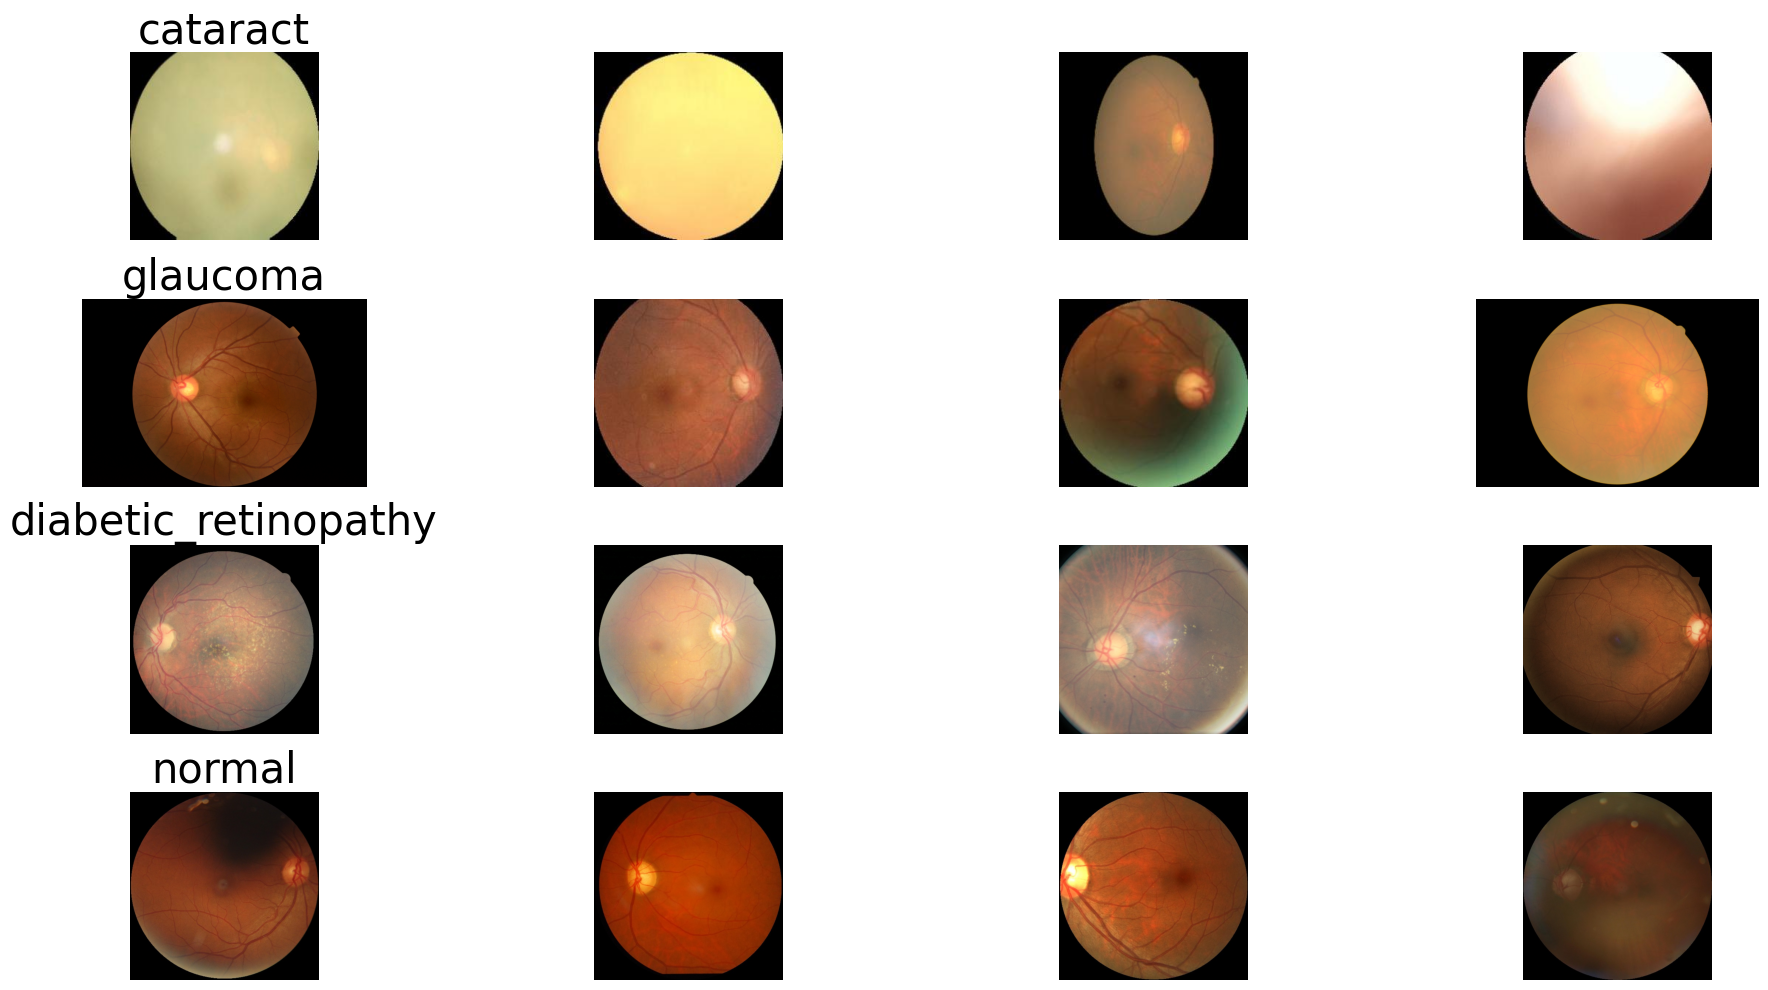

In [28]:
# Get a list of all subdirectories paths (each one is a class label)
training_split_dir = os.path.join(data_split_dir, 'training')
subdirs = [os.path.join(training_split_dir, subdir) for subdir in os.listdir(training_split_dir)]

# Specify the number of columns for your plot
ncols = 4

# Set up matplotlib fig
fig, ax = plt.subplots(len(subdirs), ncols, figsize=(20, 10))

# For each subdirectory, select random images
for i, subdir in enumerate(subdirs):
    subdir_images = os.listdir(subdir) # Get list of dir contents
    random_image_names = random.sample(subdir_images, ncols) # Get a sample of dir content
    images = [os.path.join(subdir, img_name) for img_name in random_image_names] # Append path to each sample image
    
    for j, img_path in enumerate(images):
        # Set up subplot; subplot indices start at 1
        sp = ax[i, j]
        if j == 0:
            sp.set_title(os.path.basename(subdir), fontsize=30)  # set title to the first image of each row
        sp.axis('Off') # Don't show axes (or gridlines)

        img = mpimg.imread(img_path)
        sp.imshow(img) # Show random image

plt.tight_layout()
plt.show()